In [105]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

In [106]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2,
                    feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)


In [107]:
# Define a custom dataset
class OceanDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        assert image.shape[:2] == mask.shape, f"Image and mask {self.images[idx]} do not have the same size"

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


def iou_score(output, target):
    smooth = 1e-6

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()

    output_ = output > 0.5
    target_ = target > 0.5

    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    iou = (intersection + smooth) / (union + smooth)

    return iou


In [108]:
transform = A.Compose(
    [
        # A.Resize(256, 256),
        A.RandomCrop(256, 256),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ],
    is_check_shapes=False,
)

In [109]:
# Load the dataset
# dataset = OceanDataset(
#     "./dataset/images", "./dataset/grey_binary_masks", transform=transform
# )
dataset = OceanDataset(
    "./dataset/downscaled/images", "./dataset/downscaled/masks", transform=transform
)

# Split the dataset into training, validation, and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

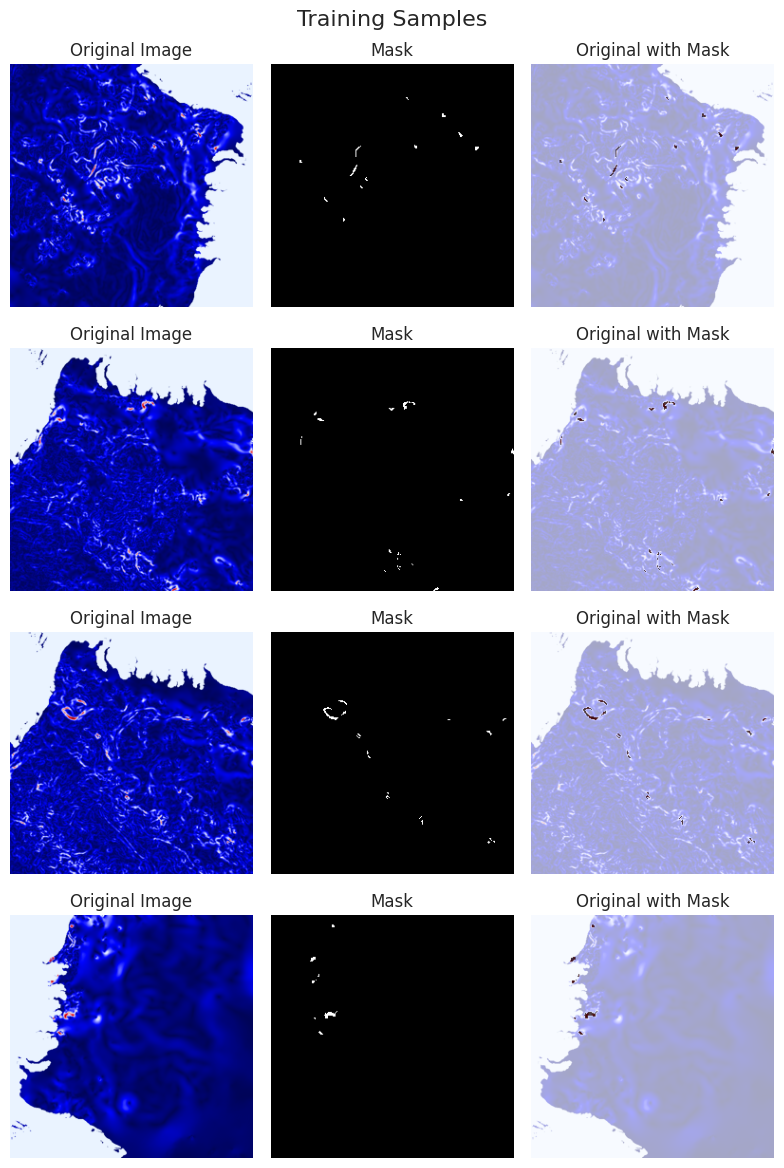

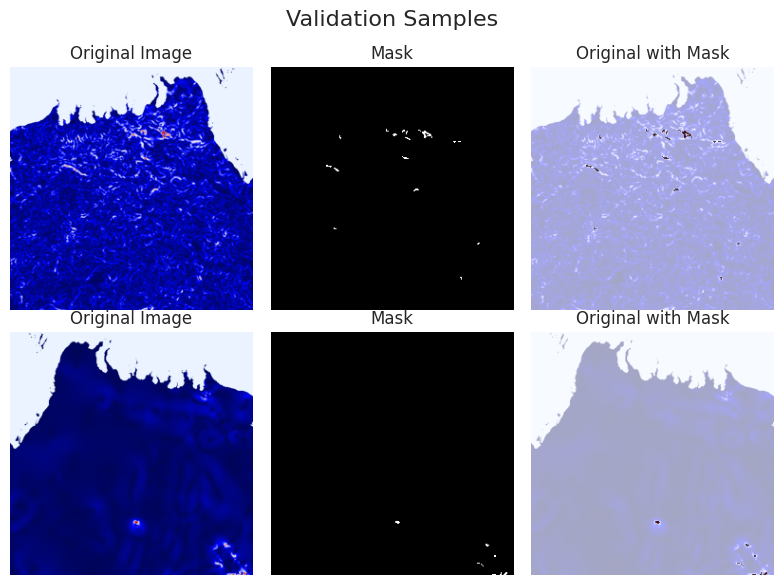

Total number of samples in the dataset: 1008
Number of samples in the training set: 644
Number of samples in the validation set: 162
Number of samples in the test set: 202


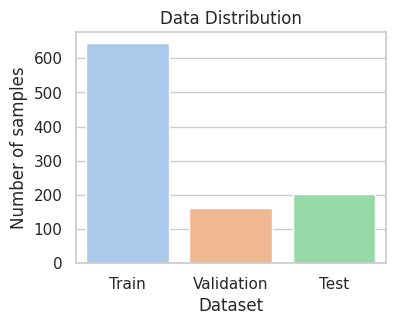

In [110]:
sns.set(style="whitegrid")
sns.set_palette("pastel")

def plot_images(data, n_images, title):
    fig, axs = plt.subplots(n_images, 3, figsize=(8, 3*n_images))

    for i in range(n_images):
        idx = np.random.randint(len(data))  # get a random index
        img, mask = data[idx]  # get the image and mask

        # convert tensors to numpy arrays and normalize to [0, 1] range
        img = img.permute(1, 2, 0).numpy()
        mask = mask.numpy()
        img = (img - img.min()) / (img.max() - img.min())
        mask = (mask - mask.min()) / (mask.max() - mask.min())

        # plot original image
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        # plot mask
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 1].set_title('Mask')
        axs[i, 1].axis('off')

        # plot original image with mask
        axs[i, 2].imshow(img)
        axs[i, 2].imshow(mask, cmap='binary', alpha=0.65)
        axs[i, 2].set_title('Original with Mask')
        axs[i, 2].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# plot 4 random images from train_data
plot_images(train_data, 4, 'Training Samples')

# plot 2 random images from val_data
plot_images(val_data, 2, 'Validation Samples')

# Dataset summary and data distribution
print(f"Total number of samples in the dataset: {len(dataset)}")
print(f"Number of samples in the training set: {len(train_data)}")
print(f"Number of samples in the validation set: {len(val_data)}")
print(f"Number of samples in the test set: {len(test_data)}")

plt.figure(figsize=(4, 3))
sns.barplot(x=['Train', 'Validation', 'Test'], y=[len(train_data), len(val_data), len(test_data)])
plt.title('Data Distribution')
plt.xlabel('Dataset')
plt.ylabel('Number of samples')
plt.show()


In [111]:
# Create data loaders
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Initialize the model, optimizer, and loss function
model = UNet()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.BCEWithLogitsLoss()

# Move the model and loss function to GPU
model = model.to("cuda")
criterion = criterion.to("cuda")

In [112]:
train_losses = []
val_losses = []
train_ious = []
val_ious = []
learning_rates = []

n_epochs = 3

for epoch in range(n_epochs):
    model.train()
    train_loss = []
    ious = []
    loop = tqdm(train_loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device="cuda")
        targets = targets.float().unsqueeze(1).to(device="cuda")

        # forward
        predictions = model(data)
        loss = criterion(predictions, targets)
        train_loss.append(loss.item())
        iou_score_batch = iou_score(predictions, targets)
        ious.append(iou_score_batch)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item(), iou_score=iou_score_batch)

    train_losses.append(np.mean(train_loss))
    train_ious.append(np.mean(ious))

    print(
        f"Epoch [{epoch + 1}/{n_epochs}]: Train Loss: {np.mean(train_loss):.4f}, Train IoU: {np.mean(ious):.4f}"
    )

    # Validation loop
    model.eval()
    val_loss = []
    val_iou = []
    with torch.no_grad():
        loop = tqdm(val_loader)
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device="cuda")
            targets = targets.float().unsqueeze(1).to(device="cuda")

            predictions = model(data)
            loss = criterion(predictions, targets)
            val_loss.append(loss.item())

            # Calculate IoU for each prediction-target pair in the batch
            iou_scores = [
                iou_score(pred.unsqueeze(0), target.unsqueeze(0))
                for pred, target in zip(predictions, targets)
            ]
            iou_score_batch_val = np.mean(iou_scores)  # Average IoU score for the batch
            val_iou.append(iou_score_batch_val)

            # update tqdm loop
            loop.set_postfix(loss=loss.item(), iou_score=iou_score_batch_val)

    val_losses.append(np.mean(val_loss))
    val_ious.append(np.mean(val_iou))

    print(
        f"Epoch [{epoch + 1}/{n_epochs}]: Val Loss: {np.mean(val_loss):.4f}, Val IoU: {np.mean(val_ious):.4f}"
    )

    scheduler.step()

    learning_rates.append(optimizer.param_groups[0]["lr"])

    torch.cuda.empty_cache()

100%|██████████| 81/81 [00:27<00:00,  2.97it/s, iou_score=0.366, loss=0.11]  


Epoch [1/3]: Train Loss: 0.2466, Train IoU: 0.2776


100%|██████████| 21/21 [00:02<00:00,  8.92it/s, iou_score=0.267, loss=0.11] 


Epoch [1/3]: Val Loss: 0.1098, Val IoU: 0.3003


100%|██████████| 81/81 [00:27<00:00,  2.94it/s, iou_score=0.575, loss=0.042] 


Epoch [2/3]: Train Loss: 0.0650, Train IoU: 0.4661


100%|██████████| 21/21 [00:02<00:00,  8.83it/s, iou_score=0.572, loss=0.0386]


Epoch [2/3]: Val Loss: 0.0400, Val IoU: 0.4214


100%|██████████| 81/81 [00:27<00:00,  2.91it/s, iou_score=0.755, loss=0.0253]


Epoch [3/3]: Train Loss: 0.0305, Train IoU: 0.6007


100%|██████████| 21/21 [00:02<00:00,  8.73it/s, iou_score=0.635, loss=0.0215]

Epoch [3/3]: Val Loss: 0.0230, Val IoU: 0.4923


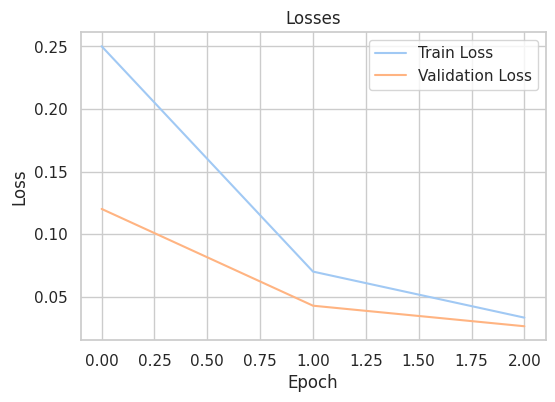

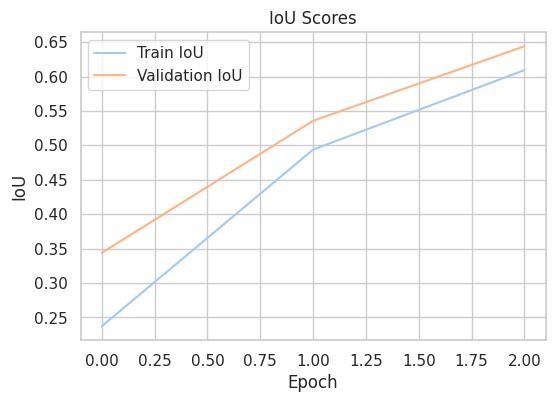

In [98]:
# Plotting loss
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting IoU
plt.figure(figsize=(6, 4))
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Validation IoU')
plt.title('IoU Scores')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(learning_rates)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Learning Rate', fontsize=14)
plt.title('Learning Rate Schedule', fontsize=16)
plt.grid(True)
plt.show()


In [96]:
# Test loop
model.eval()
test_losses = []
test_ious = []
with torch.no_grad():
    loop = tqdm(test_loader)
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device="cuda")
        targets = targets.float().unsqueeze(1).to(device="cuda")

        # forward
        predictions = model(data)
        loss = criterion(predictions, targets)
        test_losses.append(loss.item())

        iou_score_batch_test = iou_score(predictions, targets)
        test_ious.append(iou_score_batch_test)

        # update tqdm loop
        loop.set_postfix(loss=loss.item(), iou_score=iou_score_batch_test)

print(f"Test Loss: {np.mean(test_losses):.4f}, Test IoU: {np.mean(test_ious):.4f}")

100%|██████████| 26/26 [00:02<00:00,  8.73it/s, iou_score=0.553, loss=0.0215]

Test Loss: 0.0254, Test IoU: 0.6669


In [97]:
def predict_mask(model, image):
    # Ensure model is in evaluation mode
    model.eval()

    # If the image is a file path, load the image
    if isinstance(image, str):
        image = Image.open(image)

    # Apply the same transformations used on your input images during training
    transform = A.Compose(
        [
            A.Resize(256, 256),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ],
        is_check_shapes=False,
    )

    # Transform the image and add an extra dimension (for the batch)
    image = transform(image=np.array(image))['image'].unsqueeze(0).to("cuda")

    # Pass the image through the model
    with torch.no_grad():
        output = model(image)

    # The output is likely to be in the form of logits. To convert the logits to probabilities, you can use the sigmoid function
    output_probabilities = torch.sigmoid(output)

    # Remove the extra dimension and move the tensor back to the cpu
    output_probabilities = output_probabilities.squeeze(0).cpu()

    # Convert the tensor to a numpy array
    output_probabilities = output_probabilities.numpy()

    # The output is a probability map. You can convert this to a binary mask by choosing a suitable threshold
    mask = output_probabilities > 0.5

    return mask


image_path = "path_to_your_image.jpg"
mask = predict_mask(model, image_path)

# To visualize the mask, you can use matplotlib
plt.imshow(mask, cmap='gray')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_image.jpg'